<link rel="stylesheet" type="text/css" href="https://github.com/alineu/ml-projects/blob/master/css_styles/custom_style.css">

# Loading the required libraries

In [1]:
import sys
sys.path.append('util')
sys.path.append('visualization')
from viz import *
from toggle_cell import toggle_code as hide_cell
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}',r'\sansmath']
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Helvetica']})
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy import stats
from scipy.stats import norm
import os
import string
import warnings
warnings.filterwarnings('ignore')

## $\color{green}{\textbf{Opti}}\color{orange}{\textbf{Med}}$ - What $\color{orange}{\textbf{medicine}}$ $\color{green}{\textbf{best}}$ suits your need?

![](https://globalpharmaupdate.com/wp-content/uploads/2018/02/2222-1.jpg)

## The **Idea** is to Design an application that helps user find the best **OTC** medicine based on their **symptoms, preferences** and **other information**.

# Motivation

I like to break down the idea that I have into a few parts to make it more clear and enhances the thought process for potential development of each part:


- I spent some time and looked at the different data sources that I knew such as [**Data is beautiful**](https://www.reddit.com/r/dataisbeautiful), [**data.world**](https://data.world/), [**Data is plural**](https://tinyletter.com/data-is-plural/letters/data-is-plural-2020-06-17-edition), [**kaggle**](https://www.kaggle.com/datasets), [**UCI datasets**](https://archive.ics.uci.edu/ml/datasets.php) and so on and found a [**Drug Review Dataset (Drugs.com)**](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29) about cutomer reviews of 3671 unique drugs.
    
    
- I thought there are probably many people like me neither know nor look for the drug that best fits their symptoms and just go with that one drug that they always relied on when they had a headache ... So I thought about the ways that this data set can be used to find the best hit from the data set given:
 - the symptoms
 - location (living close to CVS, walgreens etc.)
 - budget
 - potential allergies or intolerance
 - other drugs being taken currently (if any) that can cause drug interactions
 - urgency of the situation (might influence the importance of the location) 
 - ...  

of the user.

# Initial Goal
- Build a natural language processing model to recommend the right medicine according to the user condition

# Future Goal
- Use other resources such as **[Drug Bank](https://www.drugbank.ca/)** to make the model more robust by considering potential ***drug interactions, side effects*** etc. 
- Use other APIs such as **[GoodRx](https://www.goodrx.com/)** to build a **real-time model** that considers other user-defined factors such as ***location, price range, and ease of transportation, weather condition, delivery options*** etc. to make a more calculated decision
- Expand the usefulness of the app to ***medical professionals*** so that they can offer ***patients-customized solutions***
</b>

# Data Exploration

The data was obtained from [UCI Drug Review Dataset (Drugs.com)](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29#). The following is the data description provided by the reference:

<div class="summary">
    <b>Data Set Information:</b>

The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The intention was to study
<ol>
<li>Sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects,</li>
<li>the transferability of models among domains, i.e. conditions, and</li>
<li>the transferability of models among different data sources (see <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/00461/">UCI Drug Review Dataset (Druglib.com)</a>).</li>
</ol>
The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.


**Important notes:**

When using this dataset, you agree that you

<ol>
<li>only use the data for research purposes</li>
<li>don't use the data for any commerical purposes</li>
<li>don't distribute the data to anyone else</li>
    <li>cite us</li>
    </ol>

**Attribute Information:**

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful

</div>


In [2]:
df_train = pd.read_csv("data/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("data/drugsComTest_raw.csv", parse_dates=["date"])

In [3]:
df_train.head(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [4]:
print("train and test shapes are {0} and {1}, respectively.".format(
    df_train.shape,df_test.shape))

train and test shapes are (161297, 7) and (53766, 7), respectively.


### Data imputation

We will exclude any cases where there is a missing value. Check all the columns for `NaN`s:

In [5]:
for col in df_train.columns:
    if df_train[col].isnull().values.any():
        print("train data has {0:d} missing values ({1:.2f}%)"
              .format(len(df_train[df_train[col].isna()]),
                      len(df_train[df_train[col].isna()]) / len(df_train)))
    if df_test[col].isnull().values.any():
        print("test data has {0:d} missing values ({1:.2f}%)"
              .format(len(df_test[df_test[col].isna()]),
                      len(df_test[df_test[col].isna()]) / len(df_test)))

train data has 899 missing values (0.01%)
test data has 295 missing values (0.01%)


We will decide on what to do with the missing elements as the number of missing values are not significant relative to the entire population. We can now make some *observations* regarding some of the features e.g. the frequency of cutomer ratings:

### Making some observations by exploring the features

We can take a look at the unique values for `uniqueID`, `drugName`, and `condition` to see whether:
- there are **multiple reviews** from a single user,
- get a sense of the number of **unique drugs** in the data set
- get a sense of different **drug categories**

In [6]:
df_all = df_train.append(df_test, ignore_index=True)
for col in ['uniqueID', 'drugName', 'condition']:
    print("{0:d} unique values for {1:s} in train data of length {2:d}"
          .format(len(df_train[col].unique().tolist()), col, len(df_train)))
    print("{0:d} unique values for {1:s} in test data of length {2:d}"
          .format(len(df_test[col].unique().tolist()), col, len(df_test)))
    print("{0:d} unique values for {1:s} in the entire data of length {2:d}"
          .format(len(df_all[col].unique().tolist()),
                  col, len(df_all)))

161297 unique values for uniqueID in train data of length 161297
53766 unique values for uniqueID in test data of length 53766
215063 unique values for uniqueID in the entire data of length 215063
3436 unique values for drugName in train data of length 161297
2637 unique values for drugName in test data of length 53766
3671 unique values for drugName in the entire data of length 215063
885 unique values for condition in train data of length 161297
709 unique values for condition in test data of length 53766
917 unique values for condition in the entire data of length 215063


We can now make some *observations* regarding some of the features e.g. the frequency of cutomer ratings:

In [7]:
unique_ratings = np.unique(df_train['rating'], return_index=False)
print(*list(unique_ratings), sep = ", ") 

1, 2, 3, 4, 5, 6, 7, 8, 9, 10


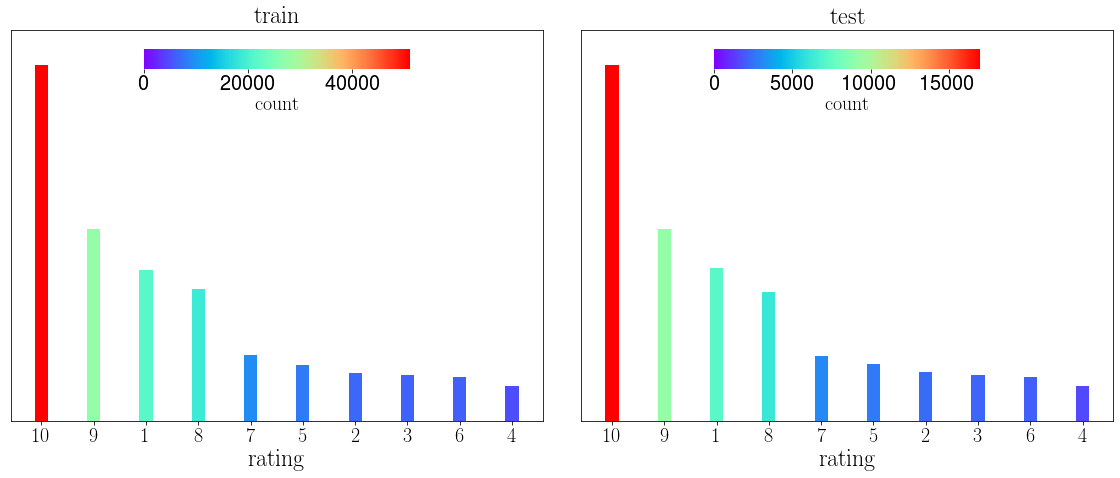

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
fig.tight_layout()
titles = ['train', 'test']
ylabs = [True, False]
train_data = df_train['rating'].value_counts()
train_data = train_data.sort_values(ascending=False)
test_data = df_test['rating'].value_counts()
test_data = test_data.sort_values(ascending=False)

for x, label, ax, title, ylab in zip([train_data.values, test_data.values],
                                     [train_data.index, test_data.index],
                                     axes, titles, ylabs):
    g = hist(x, fig=fig, ax=ax, labels=label, colmap="rainbow", show_ylab=True,
         xlabel='rating', title=title, keep_y_lab=ylab, density=False)

plt.show()

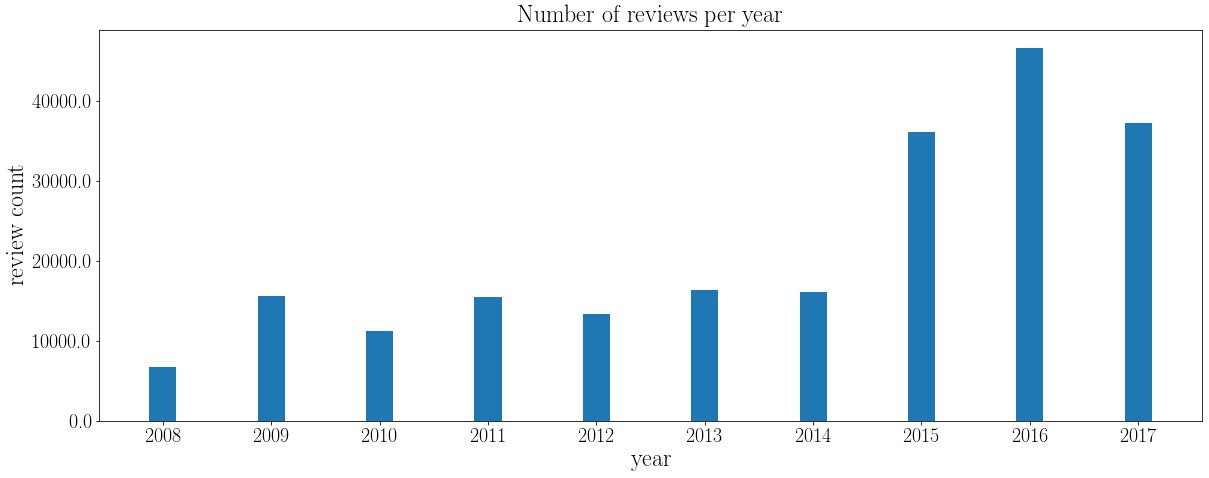

In [9]:
year_data = df_all['date'].dt.year.value_counts()
year_data = year_data.sort_index()
fig, ax = plt.subplots(1, 1, figsize=(16, 6), sharey=False)
fig.tight_layout()
hist(year_data.values, fig=fig, ax=ax, labels=year_data.index, colmap="RdYlGn", xlabel='year', colbar=False,
     title="Number of reviews per year", density=False, rot=0, ylabel='review count')

plt.show()

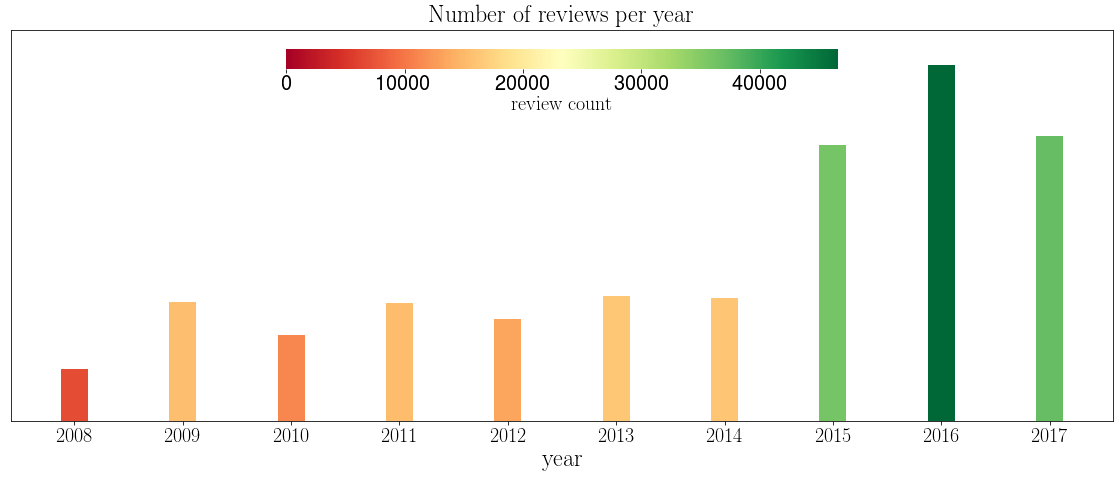

In [10]:
year_data = df_all['date'].dt.year.value_counts()
year_data = year_data.sort_index()
fig, ax = plt.subplots(1, 1, figsize=(16, 6), sharey=False)
fig.tight_layout()
hist(year_data.values, fig=fig, ax=ax, labels=year_data.index, colmap="RdYlGn", xlabel='year', colbar=True, show_ylab=True,
     title="Number of reviews per year", density=False, rot=0, ylabel='review count')

plt.show()

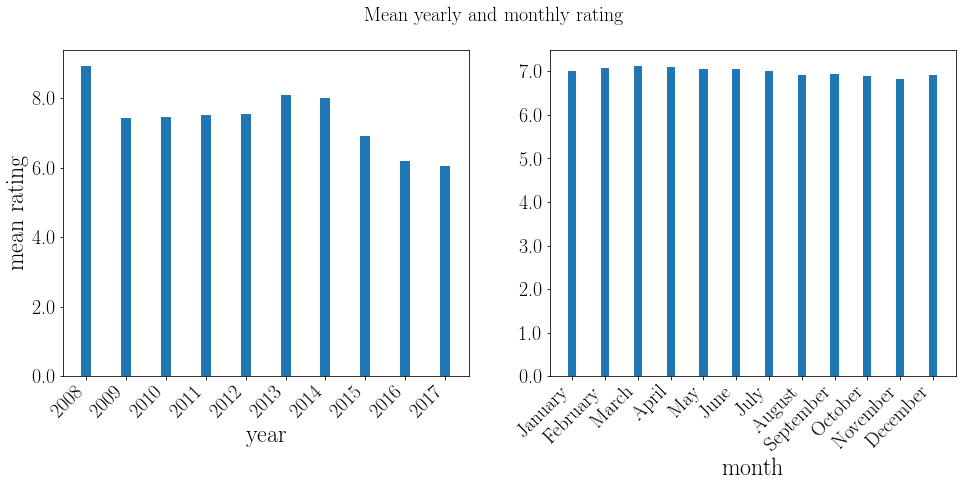

In [11]:
from calendar import month_name
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month
mean_yearly_rating = df_all.groupby('year')['rating'].mean()
mean_monthly_rating = df_all.groupby('month')['rating'].mean()
months = [month_name[x] for x in mean_monthly_rating.index]
hist(mean_yearly_rating.values, fig=fig, ax=axes[0], labels=mean_yearly_rating.index,
     colmap="RdYlGn", colbar=None, xlabel='year', ylabel='mean rating', title=None,
     density=False, rot=45)
hist(mean_monthly_rating.values, fig=fig, ax=axes[1], labels=months,
     colmap="RdYlGn", colbar=None, xlabel='month', ylabel=None, title=None,
     density=False, rot=45)
plt.suptitle("Mean yearly and monthly rating ", fontsize = 20)

plt.show()

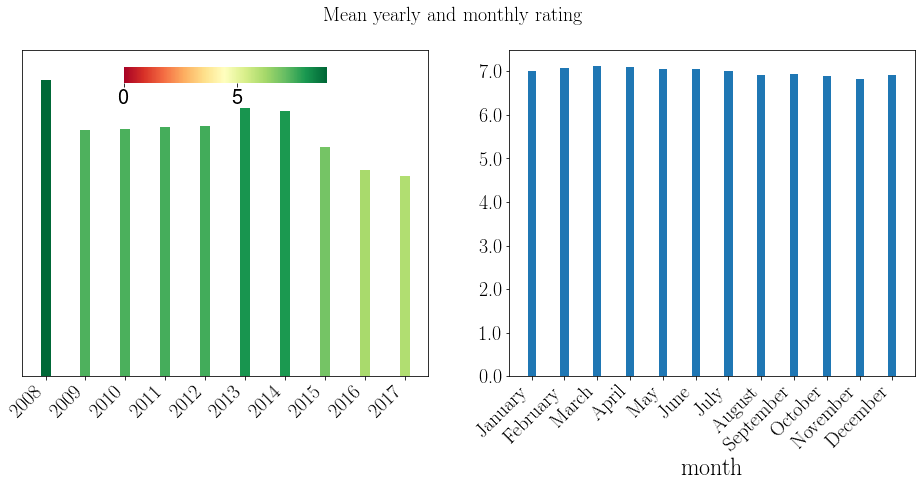

In [12]:
from calendar import month_name
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month
mean_yearly_rating = df_all.groupby('year')['rating'].mean()
mean_monthly_rating = df_all.groupby('month')['rating'].mean()
months = [month_name[x] for x in mean_monthly_rating.index]
hist(mean_yearly_rating.values, fig=fig, ax=axes[0], labels=mean_yearly_rating.index,
     colmap="RdYlGn", colbar='summer', xlabel='', ylabel='', title=None,
     density=False, rot=45)
hist(mean_monthly_rating.values, fig=fig, ax=axes[1], labels=months,
     colmap="RdYlGn", colbar=None, xlabel='month', ylabel=None, title=None,
     density=False, rot=45)
plt.suptitle("Mean yearly and monthly rating ", fontsize = 20)

plt.show()

Hmmm... Drugs getting worse? 

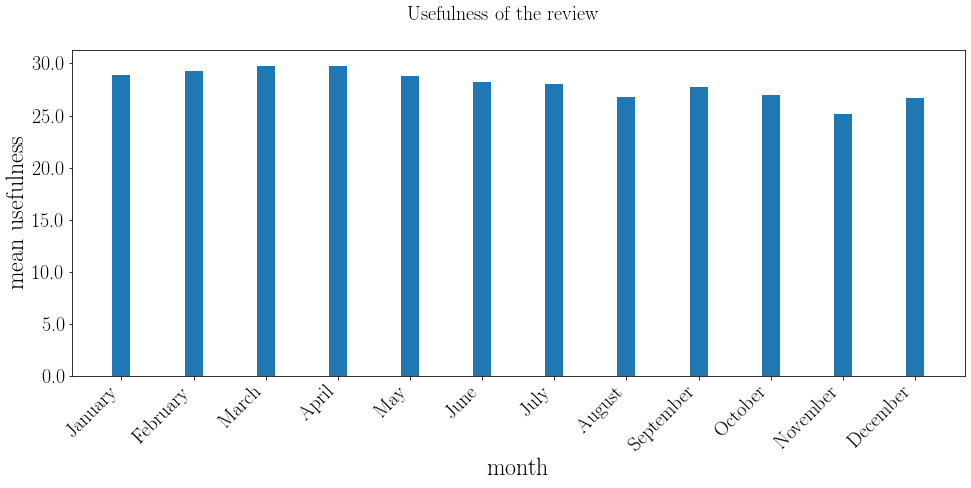

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6), sharey=False)
mean_monthly_usefulness = df_all.groupby('month')['usefulCount'].mean()
hist(mean_monthly_usefulness.values, fig=fig, ax=ax, labels=months,
     colmap="RdYlGn", xlabel='month', ylabel='mean usefulness', title=None,
     density=False, rot=45, colbar=None)
plt.suptitle("Usefulness of the review", fontsize = 20)

plt.show()

As we observe, the highly-rated reviews are more frequent compared to the poorly-rated ones. We need to **define a metric** for a <b><font color='green'>good</font></b> vs. <b><font color='red'>bad</font></b> to be able to further inspect the quality of the reviews. For now, we classify the reviews with rating below 5.5 as <b><font color='red'>bad</font></b> and otherwise <b><font color='green'>good</font></b>.

In [14]:
df_all_good = df_all[df_all["rating"] > 5.5]
df_all_bad = df_all[df_all["rating"] < 5.5]

One would expect the `drugName` and `condition` to be related in a sense that a certain `condition` e.g. *Birth Control* might be an effect produced by many drugs. Similarly, most drugs correspond to more than one condition. We can see the most number of `drugName`s with a common `condition` using **`nunique`** method of **`pandas`** which shows the unique repetitions of elements in a column or row:

In [15]:
df_all.groupby(['drugName'])['condition'].nunique(
).sort_values(ascending=False)[:10]

drugName
Prednisone       39
Gabapentin       31
Ciprofloxacin    25
Doxycycline      25
Amitriptyline    24
Neurontin        23
Metronidazole    23
Venlafaxine      23
Lyrica           22
Dexamethasone    22
Name: condition, dtype: int64

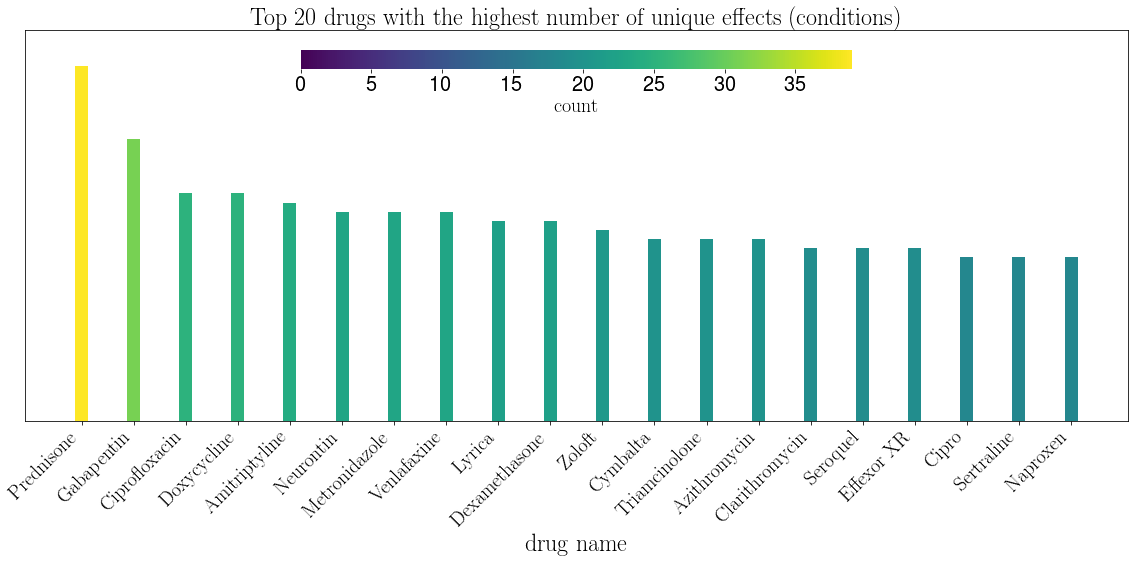

In [16]:
n_drugs = 20
drug_names = list(df_all.groupby(['drugName'])['condition'].nunique(
).sort_values(ascending=False)[:n_drugs].index)
drug_frequencies = list(df_all.groupby(['drugName'])[
                        'condition'].nunique().sort_values(ascending=False)[:n_drugs].values)
fig, ax = plt.subplots(1, 1, figsize=(16, 6), sharey=False)
fig.tight_layout()
hist(drug_frequencies, fig=fig, ax=ax, labels=drug_names, colmap="viridis", xlabel='drug name', colbar='viridis',
    show_ylab=True, title="Top {0:d} drugs with the highest number of unique effects (conditions)".format(
         n_drugs),
     density=False, rot=45)

plt.show()

Similarly, we can observe the most frequent `condition`s that are meant to be treated by all the drugs in the dataset

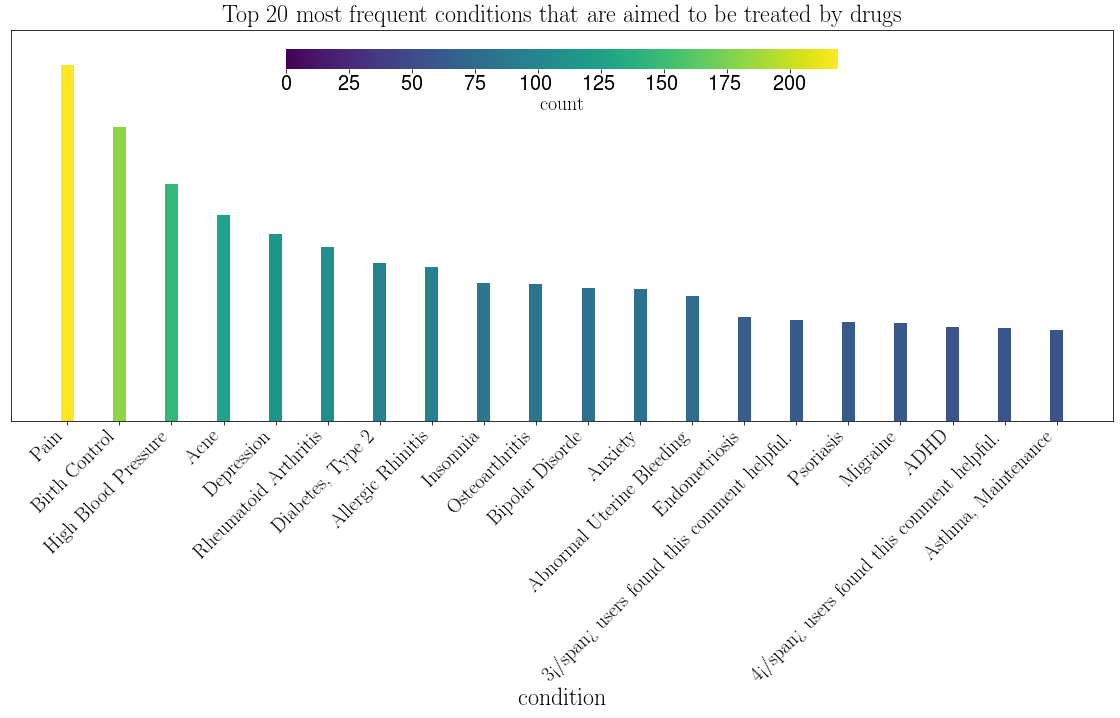

In [17]:
n_drugs = 21
top_conditions = list(df_all.groupby(['condition'])[
                      'drugName'].nunique().sort_values(ascending=False)[1:n_drugs].index)
condition_frequencies = list(df_all.groupby(['condition'])[
                             'drugName'].nunique().sort_values(ascending=False)[1:n_drugs].values)
fig, ax = plt.subplots(1, 1, figsize=(16, 6), sharey=False)
fig.tight_layout()
hist(condition_frequencies, fig=fig, ax=ax, labels=top_conditions, colmap="viridis", xlabel='condition',
     show_ylab=True, title="Top {0:d} most frequent conditions that are aimed to be treated by drugs".format(
         n_drugs-1),
     density=False, rot=45)

plt.show()

It turns out that during the data creation process from the webserver, phrases ending in ***'</span> users found this comment helpful.'*** have been mistakenly considered as a condition while they actually contain information about `usefulCount`. We can identify the rows corresponding to this error and either remove that row or keep the row and change its `consition` to **Not Listed/Other**. We choose to keep the rows. We also change **Not Listed/Othe** `condition`s to **Other**.

In [18]:
mask = df_all[['condition']].apply(lambda x: x.str.contains(
    'Not Listed|users found this comment helpful', regex=True)
).any(axis=1)
print(df_all[mask]['condition'].head(5))

105     2</span> users found this comment helpful.
196     4</span> users found this comment helpful.
243     3</span> users found this comment helpful.
264     4</span> users found this comment helpful.
391    11</span> users found this comment helpful.
Name: condition, dtype: object


In [19]:
df_all.loc[mask, 'condition'] = 'Other'

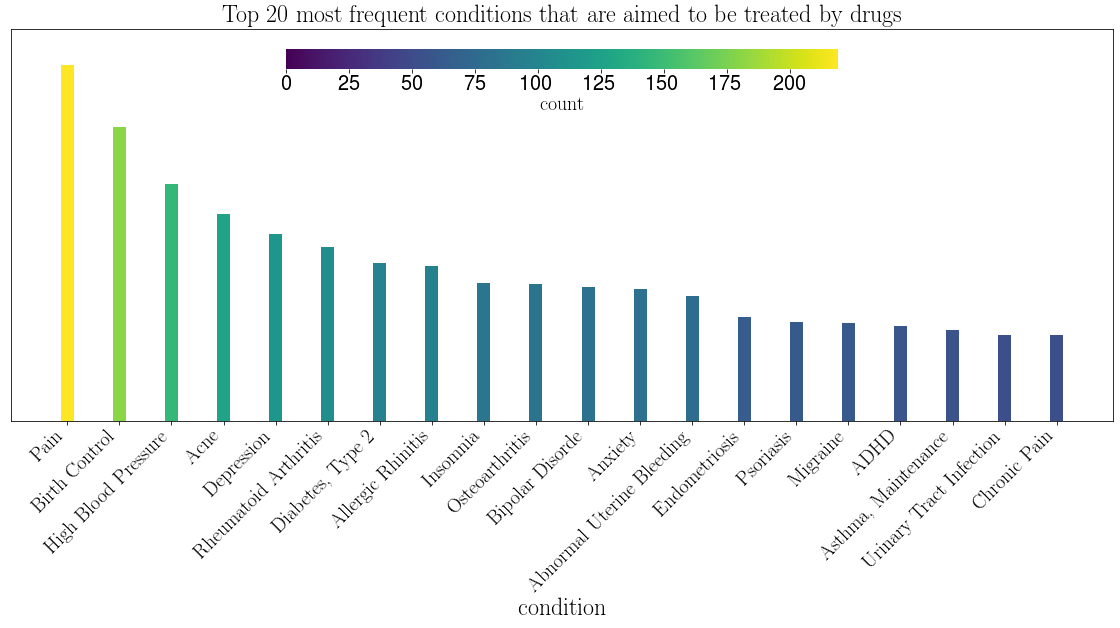

In [20]:
n_drugs = 21
top_conditions = list(df_all.groupby(['condition'])[
                      'drugName'].nunique().sort_values(ascending=False)[1:n_drugs].index)
condition_frequencies = list(df_all.groupby(['condition'])[
                             'drugName'].nunique().sort_values(ascending=False)[1:n_drugs].values)
fig, ax = plt.subplots(1, 1, figsize=(16, 6), sharey=False)
fig.tight_layout()
hist(condition_frequencies, fig=fig, ax=ax, labels=top_conditions, colmap="viridis", xlabel='condition',
     show_ylab=True, title="Top {0:d} most frequent conditions that are aimed to be treated by drugs".format(
         n_drugs-1),
     density=False, rot=45)

plt.show()

Looking at the `review` can also reveal some useful information:

In [21]:
for i in range(3):
    print("{0:s}\n".format(df_train['review'][i]))

"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"

"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the most effective."

"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestoden

There are some encoding issues that need to be resolved prior to sentiment analysis e.g. `'` is displayed as `&#039;`


### Cleaning and normalizing the text for sentiment analysis

Even though when it comes to sentiment analysis, the popular opinion is to remove **stopwords**, removing them is not always the best idea, especially if the context of the phrases may influence the performance of the algorithm. For now we will remove the **stopwords** from `review` column; after all, we can always compare the accuracy of the model when the stopwords are included and otherwise.

**stopwords** are words that we do not want them taking up space in our database, or taking up valuable processing time. For this, we can remove them easily by storing a list of words that we consider to be stop words. We then need to **tokenize** the sentence, i.e. break it up to pieces such as words, keywords, phrases, symbols etc.

We can either define our own function and use our own *ignore these words* dictionary or since there are a lot of words that have to be added to the list of **stopwords**, we can take advantage of `nltk`'s **stopwords** library

In [22]:
import re
import string
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import PorterStemmer as Stemmer
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('english')
stopWords = STOPWORDS.union(nltk_stopwords)


def tokenize(sentence):
    words = re.sub("[^\w]", " ",  sentence).split()
    cleaned_text = [w.lower() for w in words if w not in stopWords]
    return cleaned_text


def tokenize_all(sentences):
    words = []
    for sentence in sentences:
        w = word_extraction(sentence)
        words.extend(w)
        words = sorted(list(set(words)))
    return words

def clean_text(text):
    # lowercase it
    text = text.lower()
    # remove punctuation
    text = ''.join([t for t in text if t not in string.punctuation])
    # remove stopwords
    text = [t for t in text.split() if t not in stopwords.words('english')]
    # stemming
    st = Stemmer()
    text = [st.stem(t) for t in text]
    # return the cleaned text
    return text

We will also define a simple functions to generate [*n-grams*](https://kavita-ganesan.com/what-are-n-grams/#.XzP6tBNKgUE)

In [23]:
def gen_n_grams(sentence, n=4):
    token = [token for token in sentence.lower().split(
        " ") if token != "" if token not in stopWords]
    n_grams = zip(*[token[i:] for i in range(n)])
    return [" ".join(gram) for gram in n_grams]

In [24]:
print("{0:s}\n".format(df_train['review'][106]))

"So far loving this. Stomach pain has almost disappeared, haven&#039;t had an attack in over a week. Down side is have to be near a bathroom about an hour after taking it but that is manageable. Hopefully it continues to work. Time will tell."



In [25]:
%%time
print(tokenize(df_train['review'][106]))

['so', 'far', 'loving', 'stomach', 'pain', 'almost', 'disappeared', '039', 'attack', 'week', 'down', 'side', 'near', 'bathroom', 'hour', 'taking', 'manageable', 'hopefully', 'continues', 'work', 'time', 'tell']
CPU times: user 1.78 ms, sys: 1.65 ms, total: 3.42 ms
Wall time: 3.04 ms


We can visualize the most frequent words using a custom function `cloud_of_words` (from [WordCloud](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html))

in $\color{green}{\textbf{good}}$

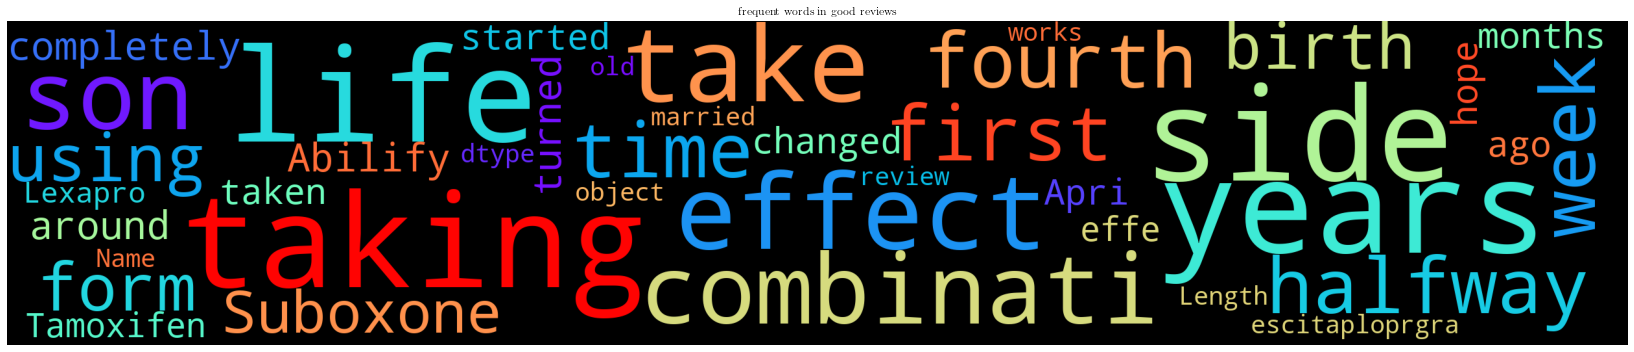

In [26]:
cloud_of_words(df_all_good['review'], stopWords=stopWords, 
               title='frequent words in good reviews', colormap='rainbow')

and in $\color{red}{\textbf{bad}}$ reviews

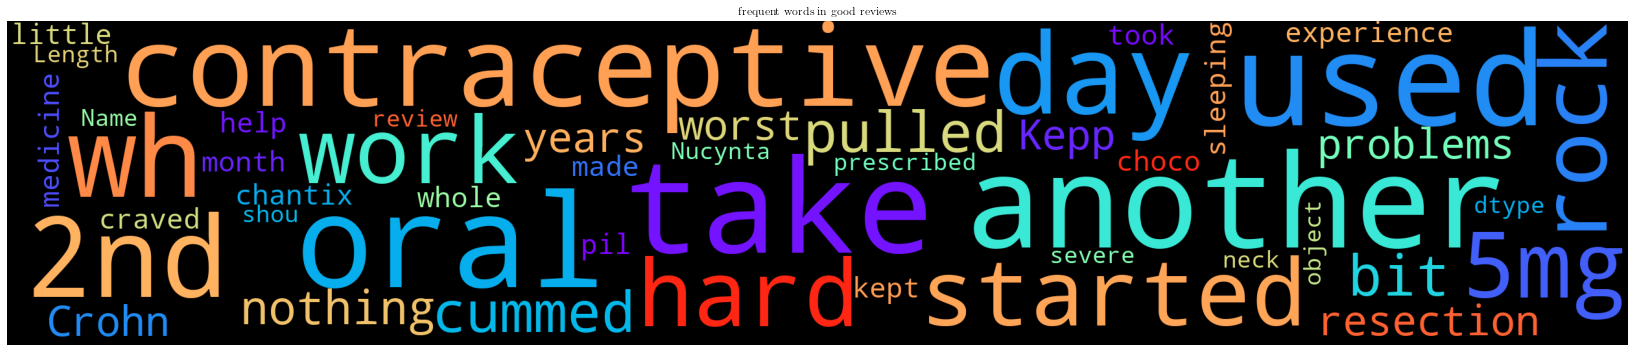

In [28]:
cloud_of_words(df_all_bad['review'], stopWords=stopWords, 
               title='frequent words in good reviews', colormap='rainbow')

### Most frequent 4-grams

In [ ]:
from matplotlib.ticker import FuncFormatter
from collections import defaultdict

frequency_dict = defaultdict(int)
for sentence in df_all_good["review"]:
    for word in gen_n_grams(sentence):
        frequency_dict[word] += 1
sorted_freq_dict = pd.DataFrame(sorted(frequency_dict.items(), key=lambda x: x[1])[::-1])
sorted_freq_dict.columns = ["word", "word_count"]

In [ ]:
good_dictionary = dict(zip(sorted_freq_dict.iloc[:5,0], sorted_freq_dict.iloc[:5,1]))
group_data = list(good_dictionary.values())
group_names = list(good_dictionary.keys())
group_mean = np.mean(group_data)
fig, ax = plt.subplots()
ax.barh(group_names, group_data)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
()

In [ ]:
frequency_dict = defaultdict(int)
for sentence in df_all_bad["review"]:
    for word in gen_n_grams(sentence):
        frequency_dict[word] += 1
sorted_freq_dict = pd.DataFrame(sorted(frequency_dict.items(), key=lambda x: x[1])[::-1])
sorted_freq_dict.columns = ["word", "word_count"]

In [ ]:
bad_dictionary = dict(zip(sorted_freq_dict.iloc[:5,0], sorted_freq_dict.iloc[:5,1]))
group_data = list(bad_dictionary.values())
group_names = list(bad_dictionary.keys())
group_mean = np.mean(group_data)
fig, ax = plt.subplots()
ax.barh(group_names, group_data)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
()